# Axial, bending and shear stiffnesses of generic beam cross-sections
$\newcommand{\dS}{\,\text{dS}}
\newcommand{\deg}{^\circ\text{C}}
\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bn}{\boldsymbol{n}}$

In this tour, we investigate the computation of stiffness moduli (axial, bending and shear) of generic beam cross-sections. In particular, we discuss the [computation of shear correction factors](#Computing-shear-correction-coefficients).

The illustrative application considers a temperature distribution on the cross-section reducing the material mechanical properties and affecting the computation of the corresponding stiffness moduli. The animation illustrates the evolution of the transverse shear stress distribution as a function of the temperature increase.

![](shear_stress_evolution.gif)



## Mechanical properties of beam cross-sections

### Symmetric homogeneous cross-section

We consider a Timoshenko beam oriented along the $x$ axis and consisting of a symmetric cross-section in the $(y,z)$ plane and made of a isotropic homogeneous elastic material (Young modulus $E$ and shear modulus $\mu$). We denote by $(y_0,z_0)$ the location of the beam axis. The beam linear elastic beahviour for planar bending in the $(x,z)$ plane is described by the following constitutive laws:
\begin{align}
N &= EA \epsilon \\
M_y &= EI_y \chi_y\\
V_z &= \kappa_z \mu A \gamma_z
\end{align}
where $\epsilon$ denotes the axial strain, $\chi_y$ the bending curvature strain and $\gamma_z$ transverse shear strain. $A$ is the cross-section area, $I_y$ the bending inertia and $\kappa_z$ is the shear correction factor described in the [next section](#Computing-shear-correction-coefficients).

### Generic heterogeneous cross-section
When the cross-section is made of a heterogeneous material, the above relation must be replaced with equivalent stiffness moduli. Moreover, when the cross-section is no longer symmetric with respect to the $z=z_0$ axis, an axial/bending coupling appears. The generic constitutive relations are therefore:
\begin{align}
N &= H_{N} \epsilon + H_{NM}\chi_y \\
M_y &= H_{NM}\epsilon + H_{M} \chi_y\\
V_z &= H_V \gamma_z
\end{align}
where $H_N$ denotes the axial stiffness modulus, $H_M$ the bending stiffness modulus, $H_{NM}$ the axial/bending coupling stiffness modulus and $H_V$ the shear stiffness modulus. These moduli are defined as follows:
\begin{align}
H_N &= \int_S E(y,z) \dS \\
H_{NM} &= \int_S E(y,z)(z-z_0) \dS \\
H_M &= \int_S E(y,z)(z-z_0)^2 \dS \\
H_V &= \kappa_z \overline{H}_V = \kappa_z \int_S \mu(y,z) \dS
\end{align}

In the homogeneous case, we indeed retrieve $H_N = E A$, $H_{NM}=EA(z_G-z_0)$, $H_M=EI_y$ and $H_V=\kappa_z\mu A$ with $z_G$ being the position of the cross-section centroid. As a result, we have no coupling ($H_{NM}=0$) when the beam axis passess through the cross-section centroid. 

> Note that we always have $\Delta_H = H_NH_M - H_{NM}^2 \geq 0$ due to the Cauchy-Schwartz inequality. This ensures that the above behaviour is well-posed.

For complex geometrical shapes, the computation of the above moduli must be done numerically, for instance using a 2D mesh of the cross-section.

### FEniCS implementation

We illustrate the computation of these various moduli for a typical box girder bridge cross-section subject to fire conditions. We consider here only the concrete cross-section and neglect the presence of steel rebars and pres-stress cables in the computation. The cross-section geometry is defined and meshed using `gmsh`. We readily compute the cross-section area and the centroid position.

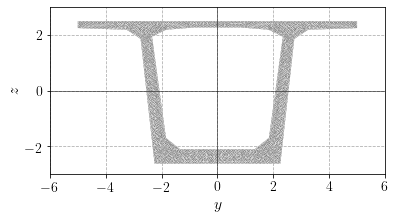

Area: 9.41 m^2
Centroid axis location: 0.09 m
Bending inertia: 35.70 m^4


In [1]:
from dolfin import *
import ufl
import matplotlib.pyplot as plt

mesh = Mesh()
with XDMFFile("box_girder_bridge.xdmf") as in_file:
    in_file.read(mesh)
htop = max(mesh.coordinates()[:, 1])
hbot = min(mesh.coordinates()[:, 1])
wleft = min(mesh.coordinates()[:, 0])
wright = max(mesh.coordinates()[:, 0])
    
    
dx = Measure("dx", domain=mesh)
x = SpatialCoordinate(mesh)

A = assemble(Constant(1.)*dx)
y_G = assemble(x[0]*dx)/A
z_G = assemble(x[1]*dx)/A

z_0 = z_G
I_y = assemble((x[1]-z_0)**2*dx)

plt.figure()
plot(mesh, linewidth=0.2)
plt.xlabel("$y$", fontsize=16)
plt.ylabel("$z$", fontsize=16)
ax = plt.gca()
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.show()

print("Area: {:.2f} m^2".format(A))
print("Centroid axis location: {:.2f} m".format(z_G))
print("Bending inertia: {:.2f} m^4".format(I_y))

Considering that the cross-section is made of a concrete material with $E=50$ GPa at ambient temperature, we assume that the bottom surface is subject to an imposed temperature $T_{fire}$ while the top surface remains at the ambient temperature $T_{amb} = 20\deg$. The remaining surfaces are assumed to have zero flux condition. We solve here a stationary heat transfer problem in order to determine the temperature field on the cross-section. This temperature field will decrease the value of the Young and shear moduli through a common stiffness reduction factor, the expression of which is assumed to be:
\begin{equation}
k(T[\deg]) \approx 
\exp\left(-\frac{T-20}{211}\right), \quad \text{for } T \geq 20^\circ\text{C}
\end{equation}
that is:
$$E(y,z)=k(T(y,z))E_{amb}, \quad \mu(y,z)=k(T(y,z))\mu_{amb}$$ 
where $E_{amb}$, $\mu_{amb}$ are the stiffness moduli at ambiant temperature.

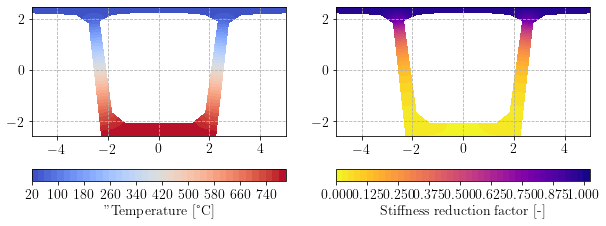

In [2]:
V = FunctionSpace(mesh, "CG", 1)
v = TestFunction(V)
u = TrialFunction(V)
T = Function(V, name="Temperature")
T_amb = Constant(20.)
T_fire = Constant(800.)

a = dot(grad(u), grad(v))*dx
L = Constant(0.)*v*dx
bc = [DirichletBC(V, T_amb, "near(x[1],{}) && on_boundary".format(htop)), 
      DirichletBC(V, T_fire, "near(x[1],{}) && on_boundary".format(hbot))]
solve(a == L, T, bc)

k = exp(-(T-20)/211)

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
pl = plot(T, cmap="coolwarm")
cbar = plt.colorbar(pl, orientation="horizontal")
cbar.set_label('"Temperature [°C]')
plt.subplot(1, 2, 2)
pl = plot(k, cmap="plasma_r")
cbar = plt.colorbar(pl, orientation="horizontal")
cbar.set_label("Stiffness reduction factor [-]")

We see that the bottom of the cross-section is strongly affected by the stiffness reduction. We now compute the various moduli at ambient temperature and the corresponding values for this temperature field.

In [3]:
E = Constant(50.)

print("Axial stiffness:")
H_N_amb = float(E)*A
H_N = assemble(k*E*dx)
print(" H_N_amb = {:.2f} GN".format(H_N_amb))
print(" H_N = {:.2f} GN".format(H_N))
print(" relative = {:+.2f}%".format(100*(H_N/H_N_amb-1)))

print("\nBending stiffness:")
H_M_amb = float(E)*I_y
H_M = assemble(k*E*(x[1]-z_0)**2*dx)
print(" H_M_amb = {:.2f} GN.m^2".format(H_M_amb))
print(" H_M = {:.2f} GN.m^2".format(H_M))
print(" relative = {:+.2f}%".format(100*(H_M/H_M_amb-1)))

print("\nCoupling stiffness:")
H_NM_amb = float(E)*(z_G-z_0)
H_NM = assemble(k*E*(x[1]-z_0)*dx)
print(" H_NM_amb = {:.2f} GN.m".format(H_NM_amb))
print(" H_NM = {:.2f} GN.m".format(H_NM))
#print(" relative = {:+.2f}%".format(100*(H_NM/H_NM_amb-1)))

Axial stiffness:
 H_N_amb = 470.42 GN
 H_N = 195.80 GN
 relative = -58.38%

Bending stiffness:
 H_M_amb = 1784.97 GN.m^2
 H_M = 836.46 GN.m^2
 relative = -53.14%

Coupling stiffness:
 H_NM_amb = 0.00 GN.m
 H_NM = 362.28 GN.m


## Computing shear correction coefficients

The Timoshenko cross-section kinematics assumes a constant distribution of transverse shear strains. The associated shear stress are also uniform for a homogeneous cross-section and therefore do not satisfy traction-free boundary conditions on the border. For a rectangular cross-section, the shear stress field induced by a uniform shear force is parabolic across the height of the section. The corresponding shear stiffness is therefore not equal to $\mu A$ as would be the case for a uniform stress field but $\kappa_z \mu A$ where $\kappa_z$ accounts for the non-constant distribution of the exact shear stress field.

### Mindlin's energetic method

Mindlin proposed to compute such a shear correction coefficient by equating, for a given value of the applied shear force, the exact elastic shear energy $U_1$ with that obtained using the simplified constant shear strain kinematics, noted $U_2$, corrected by $\kappa_z$. More precisely:
\begin{align}
U_1 &= \dfrac{1}{2}\int_S \dfrac{\sigma_{xz}^2 + \sigma_{yz}^2}{\mu(y,z)} \dS \\
U_2 &= \dfrac{1}{2} V_z \gamma_z = \dfrac{1}{2} \dfrac{V_z^2}{\kappa_z \overline{H}_V}
\end{align}
where $\sigma_{xz}(y,z)$ and $\sigma_{yz}(y,z)$ are the shear stress fields on the cross-section corresponding to an imposed vertical shear force $V_z$, that is:
\begin{equation}
V_z = \int_S \sigma_{xz}(y,z)\dS
\end{equation}

Equating $U_1=U_2$ as proposed by Mindlin's method therefore yields:
\begin{equation}
\kappa_z = \dfrac{1}{2} \dfrac{V_z^2}{U_1 \overline{H}_V}
\end{equation}

### Corresponding variational formulation

It can be shown (see [[BAT90]](#References)) that the shear stress field $\bsig(y,z) = \sigma_{xy}(y,z)\be_y + \sigma_{xz}(y,z)\be_z$ is the solution to the following linear system of equations defined on the cross-section:
\begin{equation}
\begin{cases}
\operatorname{div} \bsig + f(y,z) = 0 & \text{on } S \\
\bsig(y,z) = \mu(y,z) \boldsymbol{\nabla}u(y,z) & \\
\bsig\cdot\bn = 0 & \text{on } \partial S 
\end{cases}
\end{equation}
where $f(y,z)$ is a given source term and $u(y,z)$ is an unknown function which can be related to the warping deformation of the cross-section induced by the imposed shear force.

> Note that since the above problem is subjected to pure Neumann boundary conditions, the solution $u$ is defined up to an arbitrary constant. We must therefore enforce an additional equation (fixed value at some point, zero average, etc.) for removing this indeterminacy.

This antiplane shear elasticity problem is akin to the stationnary heat equation so that the corresponding variational formulation is straightforward: Find $u\in V$ such that:
\begin{equation}
\int_S \mu \nabla u \cdot \nabla v \dS = \int_S f u \dS \quad \forall v\in V
\end{equation}
where the source term associated with a given vertical shear force $V_z$ is given by:
\begin{equation}
f(y,z) = \dfrac{E(y,z)}{\Delta_H}((z-z_0)H_N - H_{MN})V_z
\end{equation}
where $\Delta_H = H_NH_M-H_{NM}^2$.

> Note that for the above problem with homogeneous Neumann conditions to be well posed, the source term must be of zero average on $S$. This property is ensured by construction owing to the definitions of $H_N$ and $H_{NM}$.

### Rectangular homogeneous cross section

For a rectangular homogeneous cross section $S=[-b/2;b/2\times [-h/2;h/2]$ of width $b$ and height $h$, we have:
\begin{equation}
f(y,z) = \dfrac{z}{I_y}V_z
\end{equation}
The solution of the above problem is therefore trivial and given by:
\begin{equation}
\bsig = \dfrac{1}{2 I_y}V_z\left(\frac{h^2}{4}-z^2\right)\be_z
\end{equation}
and we have:
\begin{align}
U_1 &= \dfrac{1}{2}\dfrac{1}{4 I_y^2 \mu}V_z^2 \int_S \left(\frac{h^2}{4}-z^2\right)^2 dz = \dfrac{6}{5}\dfrac{1}{\mu bh}V_z^2 \\
\overline{H}_V &= \mu b h
\end{align}
which yield the widely known shear correction factor for a rectangular cross-section:
\begin{equation}
\kappa_z = \dfrac{5}{6}
\end{equation}

### FEniCS implementation
We now define and solve the corresponding variational problem for the reduced shear modulus $\mu(y,z)=k(y,z)\mu_{amb}$. We use a mixed function space involving a scalar Lagrange multiplier to enforce a zero-average condition on $u$ as [discussed here](https://fenicsproject.org/olddocs/dolfin/latest/python/demos/neumann-poisson/demo_neumann-poisson.py.html). We also perform a sanity check that the source term is indeed of zero average.

In [4]:
nu = Constant(0.2)
mu_amb = E/2/(1+nu)
mu = k*mu_amb

Ve = FiniteElement("CG", mesh.ufl_cell(), 1)
Re = FiniteElement("R", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, MixedElement([Ve, Re]))

v, lamb_ = TestFunctions(W)
u, lamb = TrialFunctions(W)

V_z = Constant(1.)
Delta_H = H_N*H_M-H_NM**2
a_shear = dot(mu*grad(u), grad(v))*dx 
a_tot = a_shear + (u*lamb_+v*lamb)*dx
f = (H_N*(x[1]-z_0)-H_NM)/Delta_H*k*E*V_z
L_shear = f*v*dx

print("Average f:", assemble(f*dx))

Average f: -9.338840589517491e-11


We now solve the problem and extract the displacement function. The stress components are then obtained and fields are saved to a `.xdmf` file.

In [5]:
w = Function(W)
solve(a_tot == L_shear, w)

u = w.sub(0, True)
u.rename("Displacement", "")

sig_xy = Function(V, name="Shear stress xy")
sig_xy.assign(project(mu*u.dx(0), V))
sig_xz = Function(V, name="Shear stress xz")
sig_xz.assign(project(mu*u.dx(1), V))

with XDMFFile("results.xdmf") as out_file:
    out_file.parameters["functions_share_mesh"]=True
    out_file.write(u, 0)
    out_file.write(sig_xy, 0)
    out_file.write(sig_xz, 0)

Finally, the shear reduction coefficient and the corresponding shear stiffness are computed.

In [6]:
energy = 0.5*assemble(ufl.energy_norm(a_shear, w))
H_V = assemble(mu*dx)
kappa = float(V_z)**2/2/H_V/energy
print("kappa_z = {:.3f}".format(kappa))
print(" shear stiffness relative reduction: {:+.2f}%".format((kappa*H_V/float(mu_amb)/A-1)*100))

kappa_z = 0.198
 shear stiffness relative reduction: -91.74%


The corresponding shear stress distribution looks as follows:

![](shear_stress.png)

corresponding to the following warping function:

![](warping.png)

## References

[BAT90] Batoz, J. L., & Dhatt, G. (1990). Modélisation des structures par éléments finis - vol 2 - poutres et plaques. HERMES.